In [1]:
import os
import numpy as np
from keras.src.saving.saving_api import load_model
from keras import backend as K
from keras.src.utils.image_utils import img_to_array
from sklearn.model_selection import train_test_split
from keras.src.utils.numerical_utils import to_categorical
from PIL import Image
import tensorflow as tf
import pandas as pd
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import torch
import transformers

d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tải mô hình và dữ liệu cần thiết

In [2]:
#dictionary to label all traffic signs class.
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',      
            2:'Speed limit (50km/h)',       
            3:'Speed limit (60km/h)',      
            4:'Speed limit (70km/h)',    
            5:'Speed limit (80km/h)',      
            6:'End of speed limit (80km/h)',     
            7:'Speed limit (100km/h)',    
            8:'Speed limit (120km/h)',     
            9:'No passing',   
            10:'No passing veh over 3.5 tons',     
            11:'Right-of-way at intersection',     
            12:'Priority road',    
            13:'Yield',     
            14:'Stop',       
            15:'No vehicles',       
            16:'Veh > 3.5 tons prohibited',       
            17:'No entry',       
            18:'General caution',     
            19:'Dangerous curve left',      
            20:'Dangerous curve right',   
            21:'Double curve',      
            22:'Bumpy road',     
            23:'Slippery road',       
            24:'Road narrows on the right',  
            25:'Road work',    
            26:'Traffic signals',      
            27:'Pedestrians',     
            28:'Children crossing',     
            29:'Bicycles crossing',       
            30:'Beware of ice/snow',
            31:'Wild animals crossing',      
            32:'End speed + passing limits',      
            33:'Turn right ahead',     
            34:'Turn left ahead',       
            35:'Ahead only',      
            36:'Go straight or right',      
            37:'Go straight or left',      
            38:'Keep right',     
            39:'Keep left',      
            40:'Roundabout mandatory',     
            41:'End of no passing',      
            42:'End no passing veh > 3.5 tons' }


In [3]:
# Đọc dữ liệu từ file test.csv và tiền xử lý
def load_data_from_csv(csv_file):
    data = []
    labels = []
    with open(csv_file, 'r') as file:
        lines = file.readlines()[1:]  # Bỏ qua dòng tiêu đề
        for line in lines:
            parts = line.strip().split(',')
            image_path = parts[-1]
            try:
                image = Image.open(image_path)
                image = image.resize((30, 30))
                image = np.array(image)
                data.append(image)
                labels.append(int(parts[-2]))  # ClassId là phần thứ 7 từ cuối dòng
            except Exception as e:
                print(f"Error loading image: {e}")
    return np.array(data), np.array(labels)

In [4]:
# Load dữ liệu huấn luyện
X_train, y_train = load_data_from_csv("Train.csv")

In [5]:
# Load dữ liệu thử nghiệm
X_test, y_test = load_data_from_csv("test.csv")

In [6]:
# Load mô hình đã được lưu
model = load_model("my_model.h5")

d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Đánh giá hiệu suất trên dữ liệu thử nghiệm
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([16,  1, 38, ...,  6,  7, 10], dtype=int64)

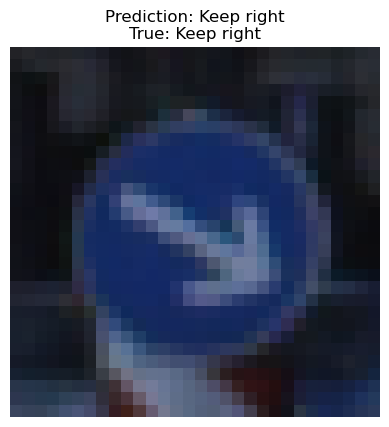

In [18]:
pic_index = np.random.randint(0, 12630)
label = y_pred_classes[pic_index]

plt.imshow(X_test[pic_index])
plt.title(f'Prediction: {classes[label]}\nTrue: {classes[y_test[pic_index]]}')

plt.axis('off')
plt.show()

# DeepFool

In [7]:
# Tính tỷ lệ nhận diện sai
def calculate_misclassification_rate(model, images, labels):
    predictions = np.argmax(model.predict(images), axis=1)
    misclassifications = np.sum(predictions != labels)
    return misclassifications / len(labels)

In [8]:
def deepfool(model, image, num_classes=10, overshoot=0.02, max_iter=50):
    image = tf.convert_to_tensor(image[None, ...], dtype=tf.float32)
    f_image = model(image).numpy().flatten()
    I = f_image.argsort()[::-1]
    label = I[0]

    input_shape = image.shape[1:]
    pert_image = np.copy(image.numpy()).reshape(-1)
    w = np.zeros_like(image.numpy()).reshape(-1)
    r_tot = np.zeros_like(image.numpy())

    loop_i = 0

    x = tf.Variable(image)

    while loop_i < max_iter and np.argmax(model(x).numpy().flatten()) == label:
        pert = np.inf
        gradients = []

        for k in range(1, min(num_classes, len(f_image))):
            with tf.GradientTape() as tape:
                tape.watch(x)
                out = model(x)
                loss = out[0, I[k]]
            grad = tape.gradient(loss, x).numpy().flatten()
            gradients.append(grad)

        if len(gradients) == 0:
            break

        for k in range(1, len(gradients)):
            w_k = gradients[k] - gradients[0]
            f_k = f_image[I[k]] - f_image[I[0]]
            pert_k = abs(f_k) / np.linalg.norm(w_k)
            if pert_k < pert:
                pert = pert_k
                w = w_k

        r_i = (pert + 1e-4) * w / np.linalg.norm(w)
        r_tot = r_tot + r_i.reshape(input_shape)  # Reshape r_i to match r_tot
        x.assign_add(tf.convert_to_tensor(r_i.reshape(image.shape)))
        pert_image = image + (1 + overshoot) * r_tot
        pert_image = np.clip(pert_image, 0, 255)

        loop_i += 1

    return pert_image.reshape(input_shape)

In [15]:
# Create adversarial examples using DeepFool
adversarial_images_deepfool = np.array([
    deepfool(model, img.astype(np.float32))
    for img in X_train[:6570]
])

C:\Users\PC\AppData\Local\Temp\ipykernel_5228\3395545769.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  pert_k = abs(f_k) / np.linalg.norm(w_k)
C:\Users\PC\AppData\Local\Temp\ipykernel_5228\3395545769.py:39: RuntimeWarning: invalid value encountered in multiply
  r_i = (pert + 1e-4) * w / np.linalg.norm(w)


In [16]:
# Create directory for adversarial images if it doesn't exist
adv_train_dir = 'adv_train'
if not os.path.exists(adv_train_dir):
    os.makedirs(adv_train_dir)

# Save adversarial images to the directory
for i, adv_img in enumerate(adversarial_images_deepfool):
    adv_img = Image.fromarray(adv_img.astype(np.uint8))
    adv_img.save(os.path.join(adv_train_dir, f"adv_img_{i}.png"))

C:\Users\PC\AppData\Local\Temp\ipykernel_5228\788418703.py:8: RuntimeWarning: invalid value encountered in cast
  adv_img = Image.fromarray(adv_img.astype(np.uint8))


NameError: name 'adversarial_images_deepfool' is not defined

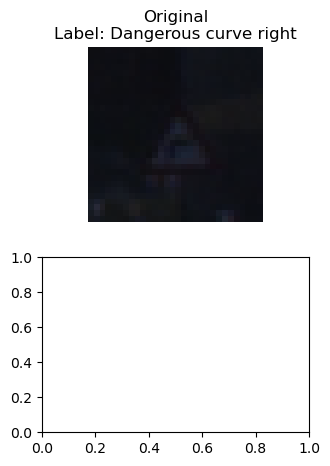

In [26]:
# Display some original and adversarial images starting from image 781
start_index = 125
num_images_to_show = 5
plt.figure(figsize=(20, 5))
for i in range(num_images_to_show):
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(X_train[start_index + i].astype(np.uint8))
    plt.title(f"Original\nLabel: {classes[y_train[start_index + i]]}")
    plt.axis('off')
    
    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(adversarial_images_deepfool[start_index + i].astype(np.uint8))
    plt.title(f"Adversarial\nLabel: {classes[np.argmax(model.predict(adversarial_images_deepfool[start_index + i:start_index + i + 1]))]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Xử lý ảnh đã được thêm nhiễu

In [16]:
def load_train_data(csv_path):
    # Đọc dữ liệu từ file CSV
    train_data = pd.read_csv(csv_path)
    return train_data

In [17]:
ignore_image = [] # Những ảnh đã được lọc thủ công
def load_perturbate_images(num_images, perturbate_folder):
    perturbate_images = []
    for i in range(num_images):
        image_path = f'{perturbate_folder}/adv_img_{i}.png'
        try:
            image = Image.open(image_path)
            image = image.resize((30, 30))  # Thay đổi kích thước ảnh nếu cần
            image = np.array(image)
            perturbate_images.append(image)
        except Exception as e:
            ignore_image.append(i)

    return np.array(perturbate_images)

In [9]:
def map_perturbate_to_labels(train_data, num_images):
    # Giả sử thứ tự của các ảnh perturbate khớp với thứ tự của các ảnh trong train.csv
    y_per = train_data['ClassId'][:num_images].to_numpy()
    return y_per

In [18]:
# Đường dẫn tới file train.csv và thư mục chứa các ảnh perturbate
csv_path = 'Train.csv'
perturbate_folder = 'deepfool_train'

# Đọc dữ liệu từ train.csv
train_data = load_train_data(csv_path)

# Số lượng ảnh perturbate
# num_images = 6554  # Điều chỉnh theo số lượng ảnh thực tế của bạn
num_images = 6554  # Điều chỉnh theo số lượng ảnh thực tế của bạn


# Đọc ảnh perturbate và tạo nhãn y_per tương ứng
X_per = load_perturbate_images(num_images, perturbate_folder)
y_per = map_perturbate_to_labels(train_data, num_images)
y_per = np.delete(y_per, ignore_image)

print(f'Đã tải {len(X_per)} ảnh nhiễu.')
print(f'Nhãn thực tế: {y_per}')
print(f'Những ảnh đã được loại bỏ {ignore_image}')

Đã tải 505 ảnh nhiễu.
Nhãn thực tế: [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2

In [19]:
len(y_per)

505

In [20]:
y_pred = model.predict(X_per)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([32, 25, 26, 25, 18, 26, 32, 30, 18,  2, 28, 36, 11, 24, 18, 28, 25,
       25, 16, 25, 28, 20,  9, 23, 18, 31, 25,  2, 23, 22, 22, 11, 23, 30,
       23, 30, 18, 30, 25, 29, 25,  5, 25, 24,  1,  1, 24, 28, 30, 28,  1,
       29, 30, 34, 18, 23, 25, 18, 18, 18, 11, 20, 25, 21, 25,  2,  0, 25,
       25, 41, 24, 18, 24, 25, 20, 25, 16, 23, 11, 24,  4,  4, 14, 10,  0,
        0,  8,  4,  1, 12,  4,  4,  6,  5,  0,  0,  2,  1, 18, 25,  1,  2,
        2,  5, 40,  2,  5,  1, 15, 40,  4, 40, 40, 40, 15, 18,  2,  2,  4,
       32,  4,  5,  1,  5,  4,  4,  7,  2,  8,  7,  8,  5,  5,  7,  7,  5,
        6,  0,  2, 12, 15, 15, 25,  4, 15,  1,  4, 21,  2,  5,  5,  2,  0,
       25,  1,  5,  5,  1,  5, 18,  4, 32,  5,  4, 12, 18,  2,  4,  0,  5,
       10,  3,  5,  3,  2,  5,  2,  1,  1,  4, 32,  2,  1, 38, 18, 41,  2,
        5, 10, 31,  3,  3,  3,  2,  1,  6,  4,  4,  2,  1,  3,  4,  2,  3,
        2,  8,  3,  4, 31, 32,  0,  2,  5,  5, 31, 12,  8,  6,  8,  5,  4,
        7,  1,  4,  4,  2

In [21]:
accuracy = accuracy_score(y_per, y_pred_classes)
print(f"Accuracy sau khi thêm nhiễu: {accuracy}")

Accuracy sau khi thêm nhiễu: 0.14257425742574256


In [23]:
def combine_datasets(X_train, X_per, y_train):
    X_combined = np.concatenate([X_train, X_per])
    y_combined = np.concatenate([y_train, y_train])
    return X_combined, y_combined

In [24]:
X_train = X_train.squeeze()

In [25]:
import numpy as np
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping

In [ ]:
def adversarial_training(model, X_train, y_train, batch_size=32, epochs=10):
    
    # Kết hợp dữ liệu gốc và dữ liệu nhiễu
    X_combined, y_combined = combine_datasets(X_train, X_per, y_train)
    
    # Compile model
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    # Huấn luyện mô hình
    early_stopping = EarlyStopping(monitor='loss', patience=3)
    model.fit(X_combined, y_combined, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])
    
    return model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


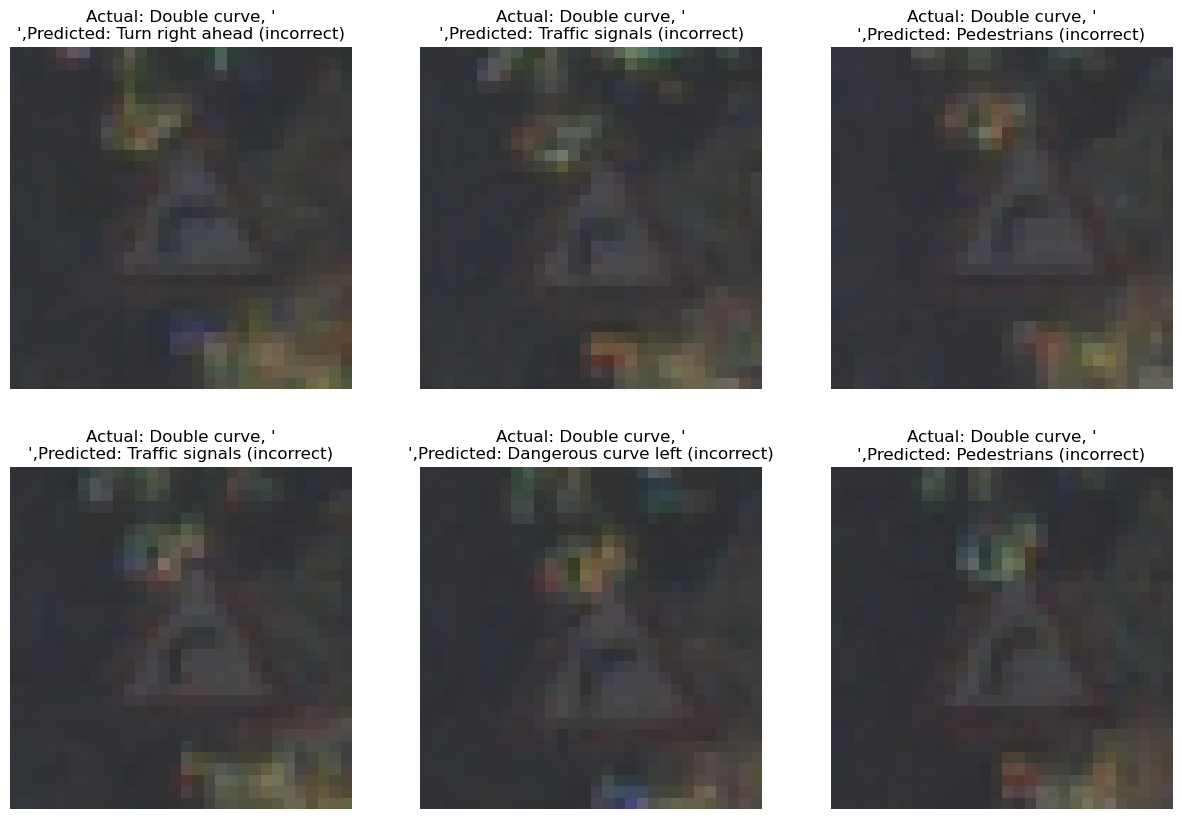

In [22]:
# Chọn 6 ảnh đầu tiên từ tập dữ liệu thử nghiệm để dự đoán và đánh giá
num_samples = 6
X_per_sample = X_per[:num_samples]
y_per_sample = y_per[:num_samples]

# Dự đoán và lấy nhãn dự đoán cho 6 ảnh đầu tiên
y_pred = model.predict(X_per_sample)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot các ảnh và dự đoán của mô hình
plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_per_sample[i])
    actual_label = y_per_sample[i]+1
    predicted_label = y_pred_classes[i]+1
    predicted_class_name = classes[predicted_label]
    if actual_label == predicted_label:
        plt.title(f"Actual: {classes[actual_label]}\nPredicted: {predicted_class_name}")
    else:
        plt.title(f"Actual: {classes[actual_label]}, '\n',Predicted: {predicted_class_name} (incorrect)")
    plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


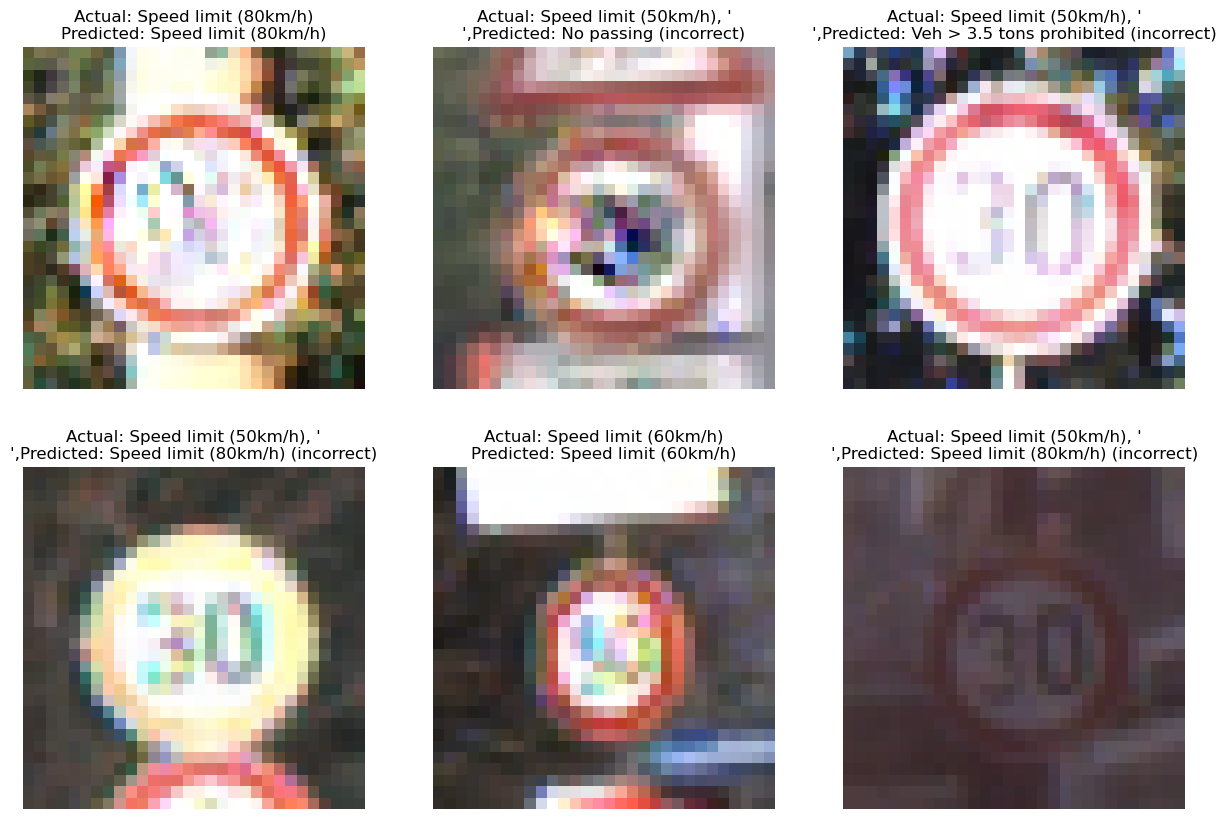

In [29]:
import numpy as np

# Chọn ngẫu nhiên 6 chỉ mục từ 0 đến 505
random_indices = np.random.choice(506, size=num_samples, replace=False)
X_per_sample = X_per[random_indices]
y_per_sample = y_per[random_indices]

# Tiếp tục với các bước còn lại như trong mã gốc
y_pred = model.predict(X_per_sample)
y_pred_classes = np.argmax(y_pred, axis=1)

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_per_sample[i])
    actual_label = y_per_sample[i]+1
    predicted_label = y_pred_classes[i]+1
    predicted_class_name = classes[predicted_label]
    if actual_label == predicted_label:
        plt.title(f"Actual: {classes[actual_label]}\nPredicted: {predicted_class_name}")
    else:
        plt.title(f"Actual: {classes[actual_label]}, '\n',Predicted: {predicted_class_name} (incorrect)")
    plt.axis('off')
plt.show()
